# CNN

In [1]:
import tensorflow.keras as keras

In [2]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import os as os
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from time import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [4]:
keras.__version__

'2.2.4-tf'

# 10-FOLD

In [5]:
subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
global activities
activities = [9,10,11,12,13,19,20,21,24,25,31]

In [6]:
# Ajustado a los datos
n_time_steps = 128
n_classes = 11 # Nº de clases (el 0 está eliminado)
n_channels = 1 # Nº de canales
n_columns = 20

# Podríamos variarlo
batch_size = 128 # Tamaño del batch
learning_rate = 1e-3 # Learning rate (por defecto es 0.001)
epochs = 100 # Épocas

In [7]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each corresponding
        # epoch
        lrs = [self(i) for i in epochs]
 
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
 
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        if(alpha<1e-9):
            alpha=1e-9

        # return the learning rate
        return float(alpha) 

schedule = StepDecay(initAlpha=learning_rate, factor=0.4, dropEvery=10)

reduce_lr = keras.callbacks.LearningRateScheduler(schedule, verbose = 1)
callbacks_list = [reduce_lr]

In [8]:
#Visualize training evolution
def plot_curves(model, acc, loss, val_acc, val_loss, kfold):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./01RAW_RP_KFOLD_models/loss_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01RAW_RP_KFOLD_models/loss_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./01RAW_RP_KFOLD_models/acc_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01RAW_RP_KFOLD_models/acc_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./01RAW_RP_KFOLD_models/all_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01RAW_RP_KFOLD_models/all_train_01RAW_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')

In [9]:
def plot_confusion_matrix(y_true, y_pred, kfold, classes,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, square = True, robust = True, annot=True, cmap='YlOrBr')
    plt.title('CONFUSION MATRIX')
    plt.ylabel('TRUE ACTIVITY')
    plt.xlabel('PREDICTION')
    
    locs, labels = plt.xticks()
    plt.xticks(locs, labels, rotation='vertical')
    locs, labels = plt.yticks()
    plt.yticks(locs, labels, rotation='horizontal')

    # Guardamos la imagen en formato vectorial
    plt.draw()
    plt.savefig('./01RAW_RP_KFOLD_models/matriz_confusion_'+kfold+'.svg', bbox_inches='tight',format='svg')
    plt.show()

In [10]:
from sklearn.model_selection import KFold
S = np.arange(0,1078)
kf = KFold(n_splits=10)
kf.get_n_splits(S)

print(kf)  

S_train = []
S_test = []

for train_index, test_index in kf.split(S):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(S[train_index])
    print(S[test_index])
    S_train.append(S[train_index])
    S_test.append(S[test_index])

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 108  109  110  111  112  113  114  115  116  117  118  119  120  121
  122  123  124  125  126  127  128  129  130  131  132  133  134  135
  136  137  138  139  140  141  142  143  144  145  146  147  148  149
  150  151  152  153  154  155  156  157  158  159  160  161  162  163
  164  165  166  167  168  169  170  171  172  173  174  175  176  177
  178  179  180  181  182  183  184  185  186  187  188  189  190  191
  192  193  194  195  196  197  198  199  200  201  202  203  204  205
  206  207  208  209  210  211  212  213  214  215  216  217  218  219
  220  221  222  223  224  225  226  227  228  229  230  231  232  233
  234  235  236  237  238  239  240  241  242  243  244  245  246  247
  248  249  250  251  252  253  254  255  256  257  258  259  260  261
  262  263  264  265  266  267  268  269  270  271  272  273  274  275
  276  277  278  279  280  281  282  283  284  285  286  287  288  289
  290  291  292  

##################################################################################################################################
#####################################################  K-FOLD 1  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


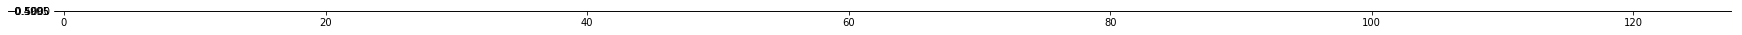

Activity:  10


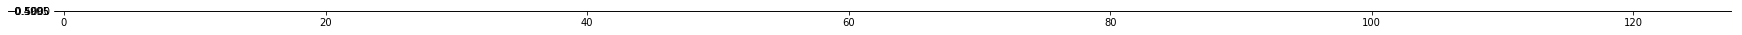

Activity:  13
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 5)         0       

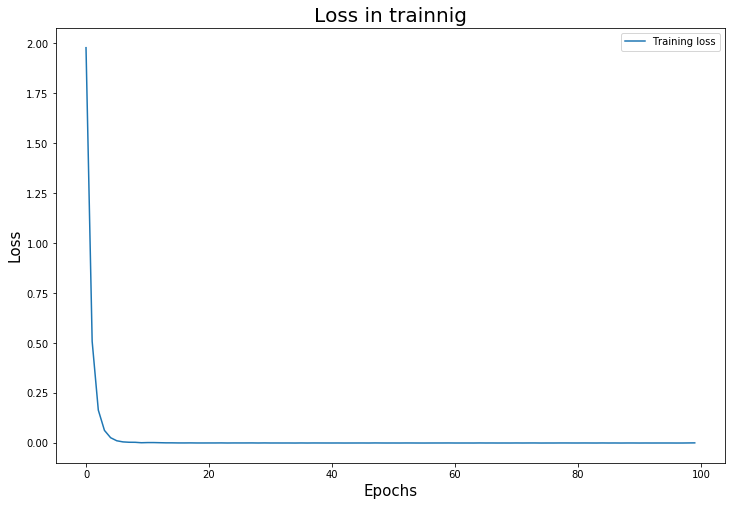

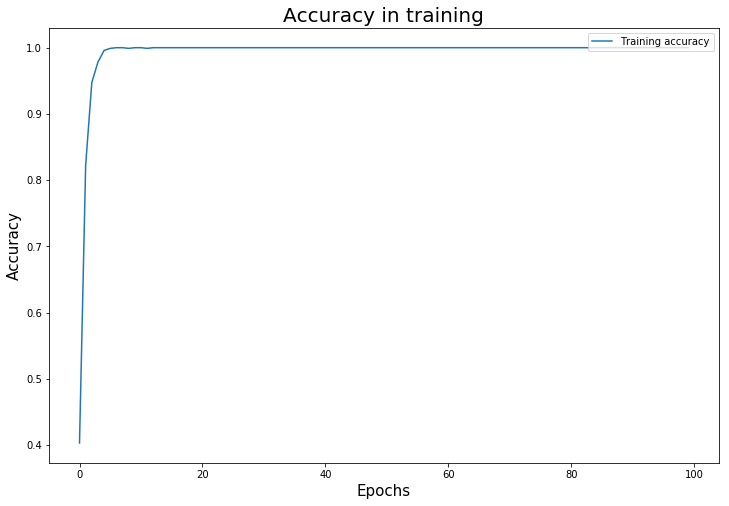

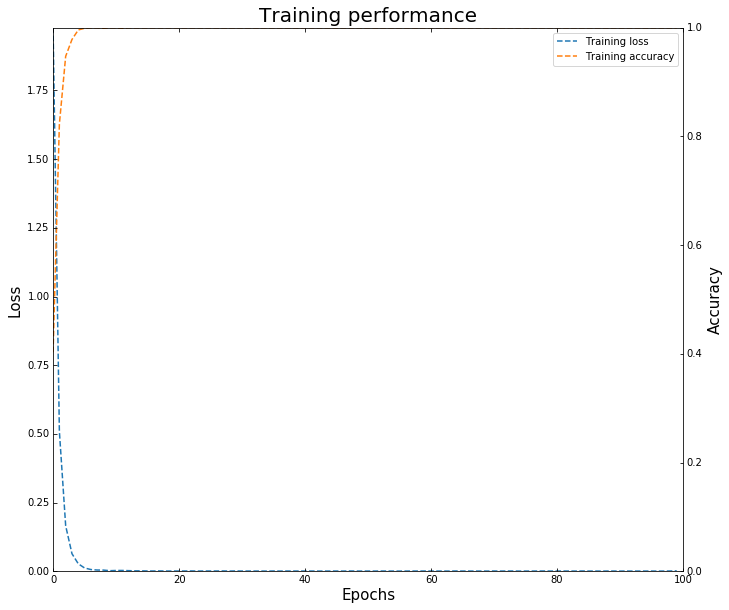

108/108 [==============================] - 0s 2ms/sample
(108, 11)
[[ 2  7  7  5  0  6  7  8  3  7 10  0  1  7  3 10  2  2  8  1 10  6 10  1
   8  3  4  1  0  6  0  3  0 10  1 10  3  5  7  2  1  2  2  1  0  8  1  6
   8  6  7  0  0  8  1  2  7  8 10  7  4 10  1  7  3 10  3 10 10 10  4  1
   1  8  6  7  3  4  7  7  2  7  5  1  1  8  2  6  1  7  7 10  7  0  3  0
   7  7  1  4]]
(108, 1)
[[ 2  7  9  4  0  5  7  8  3  7 10  0  4  9  3  6  2  2  8  1 10  5 10  4
   8  3  6  1  0  5  0  3  0 10  1  6  3  4  5  2  4  2  2  4  5  8  1  5
   8  5  9  0  0  8  1  2  9  8  6  9  6 10  1  7  3  6  3 10  6 10  6  1
   1  8  5  9  3  6  9  7  2  9  4  4  4  8  2  5  1  7  7 10  7  0  3  0
   9  7  1  4]]
108/108 [==============================] - 0s 2ms/sample - loss: 1.2463 - categorical_accuracy: 0.6667


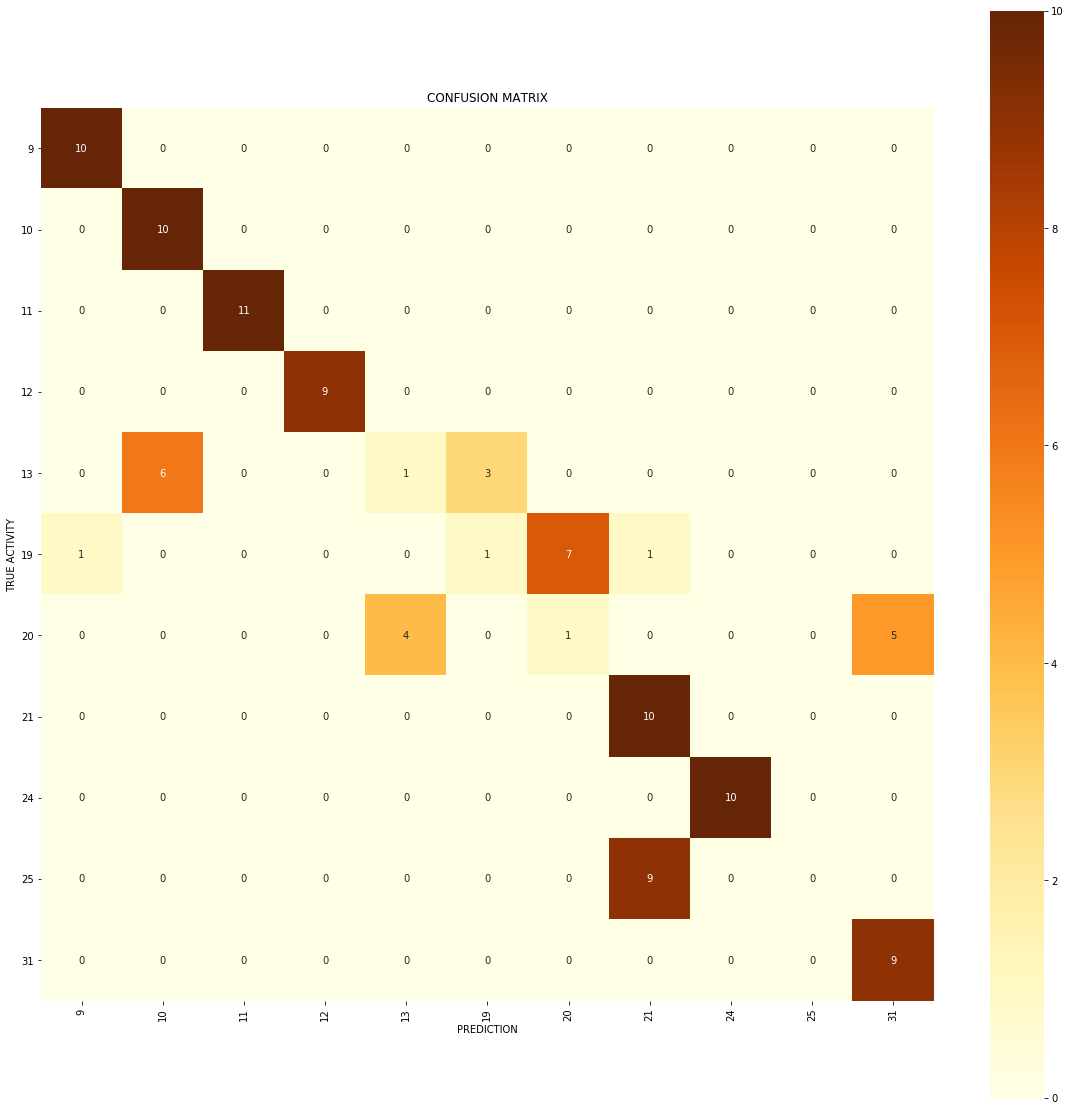

##################################################################################################################################
#####################################################  K-FOLD 2  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


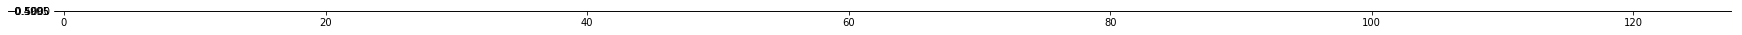

Activity:  11


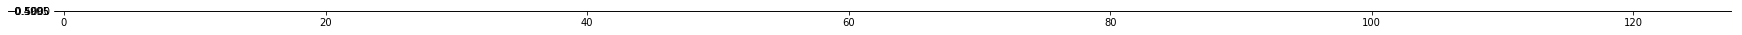

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 5)   

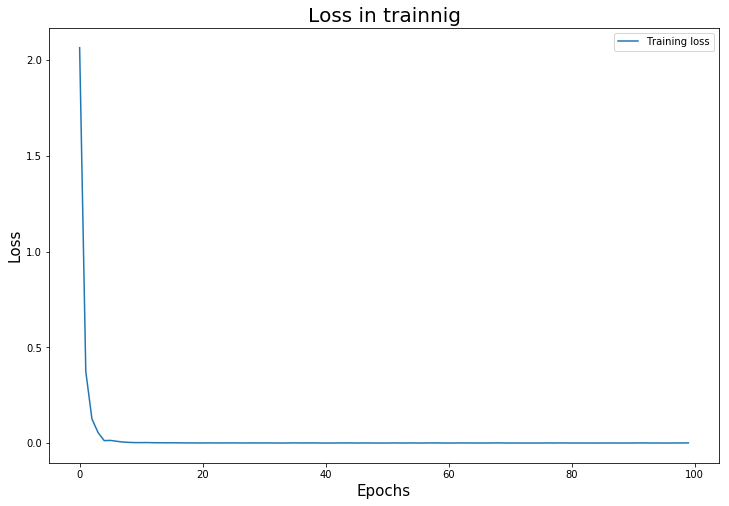

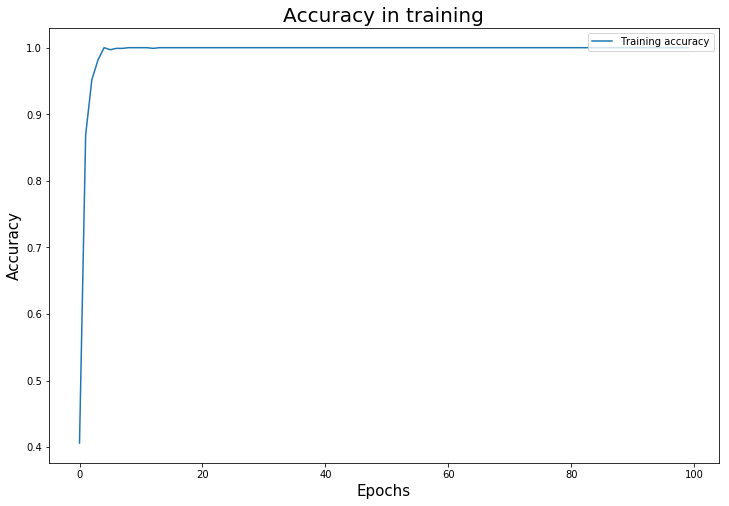

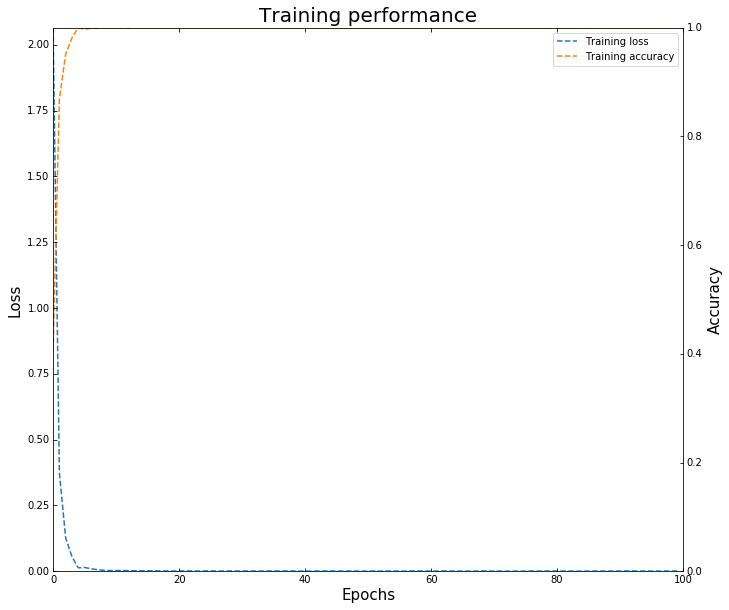

108/108 [==============================] - 0s 942us/sample
(108, 11)
[[ 1  5  9  4  5  2  4  9  1  9  4  0  8  1  0  2  1  8  3  9  6  7  6  9
   8  3  8  7  1 10  0 10  5  4  4  0  7  6  7 10  5  3  7  9 10  8  0  2
   1  3  0  9  6  0  8  9 10  1  5  6  5  6  5  7  3  8  1  4  3  3  8  3
   3  2  2  6  2 10  0 10  9  7  2  4  6  5  7  4  7  0 10  4  9  1  0  9
   6  2  2  5]]
(108, 1)
[[ 1  5  9  4  5  2  4  9  1  9  4  0  8  1  0  2  1  8  3  9  6  7  6  9
   8  3  8  7  1 10  0 10  5  4  4  0  7  6  7 10  5  3  7  9 10  8  0  2
   1  3  0  9  6  0  8  9 10  1  5  6  5  6  5  7  3  8  1  4  3  3  8  3
   3  2  2  6  2 10  0 10  9  7  2  4  6  5  7  4  7  0 10  4  9  1  0  9
   6  2  2  5]]
108/108 [==============================] - 0s 1ms/sample - loss: 0.0316 - categorical_accuracy: 1.0000


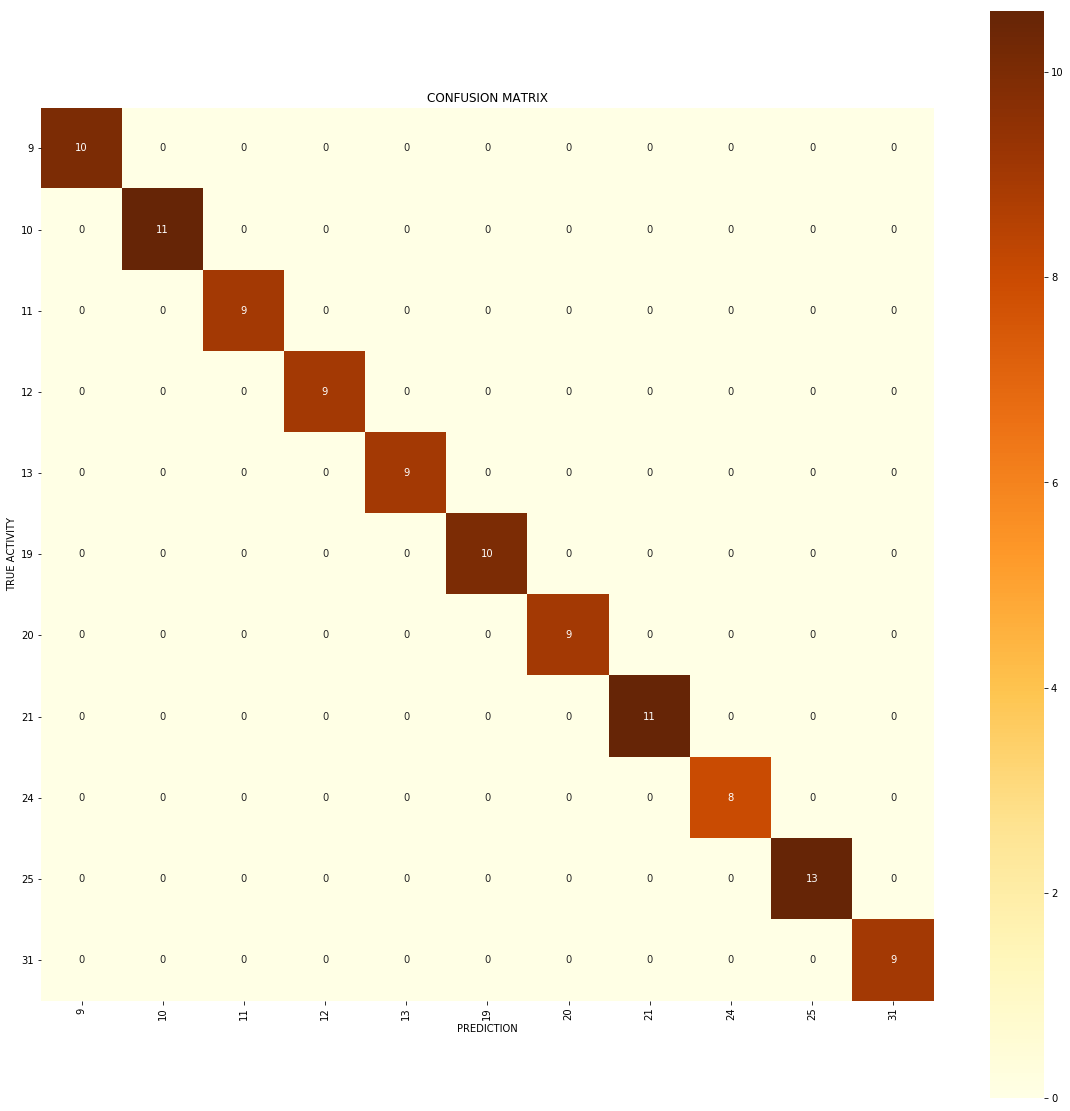

##################################################################################################################################
#####################################################  K-FOLD 3  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


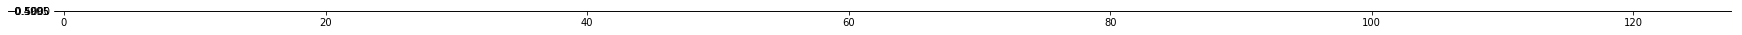

Activity:  11


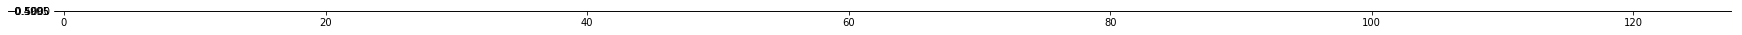

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 5)   

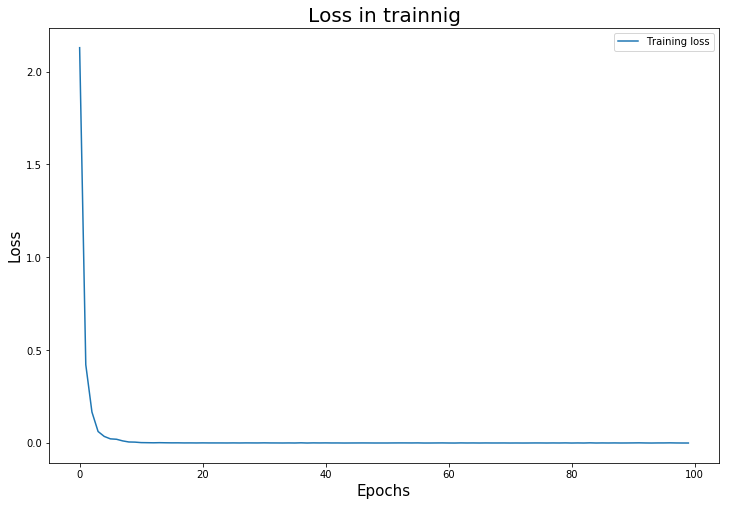

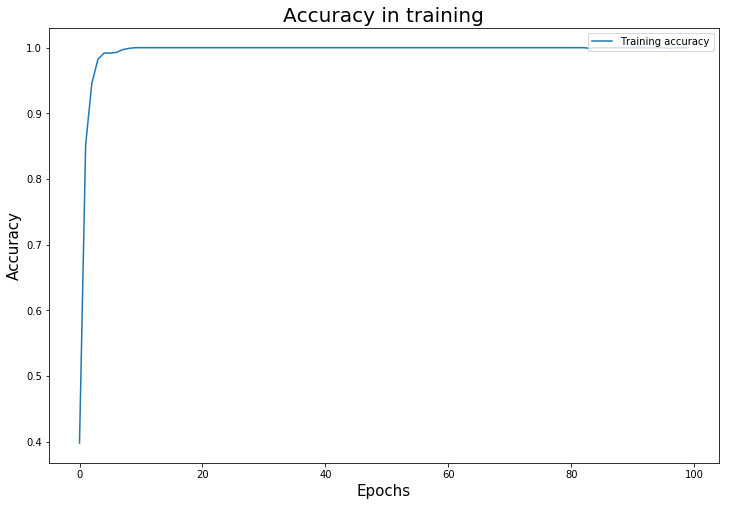

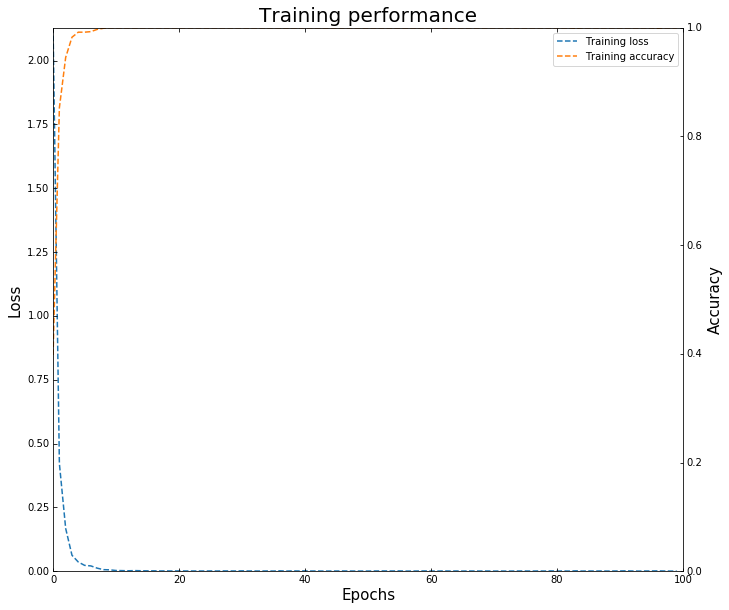

108/108 [==============================] - 0s 1ms/sample
(108, 11)
[[ 3  1  9  2  6  7  9  1  4  7 10  1  3  0  4 10 10  5  9  4  5  2  9  9
   6  5  0  0  5  3  0  3  9  9  0  4  2  6  6  9  2  2  7  0 10  9  3  9
   3  1  1  5 10  7  4 10  2  9  5  2  6  6  3  6  0  7  9  6  4  3  7  4
   4  3  9  5  9  1  9  0  8 10  2 10 10  4  6 10  2  1  3  2  0  8  0  5
   2  3  9  4]]
(108, 1)
[[ 3  1  8  2  6  7  8  1  4  7 10  1  3  0  4 10 10  5  8  4  5  2  9  8
   6  5  0  0  5  3  0  3  8  9  0  4  2  6  6  8  2  2  7  0 10  9  3  8
   3  1  1  5 10  7  4 10  2  8  5  2  6  6  3  6  0  7  9  6  4  3  7  4
   4  3  8  5  9  1  9  0  8 10  2 10 10  4  6 10  2  1  3  2  0  8  0  5
   2  3  9  4]]
108/108 [==============================] - 0s 1ms/sample - loss: 0.1575 - categorical_accuracy: 0.9167


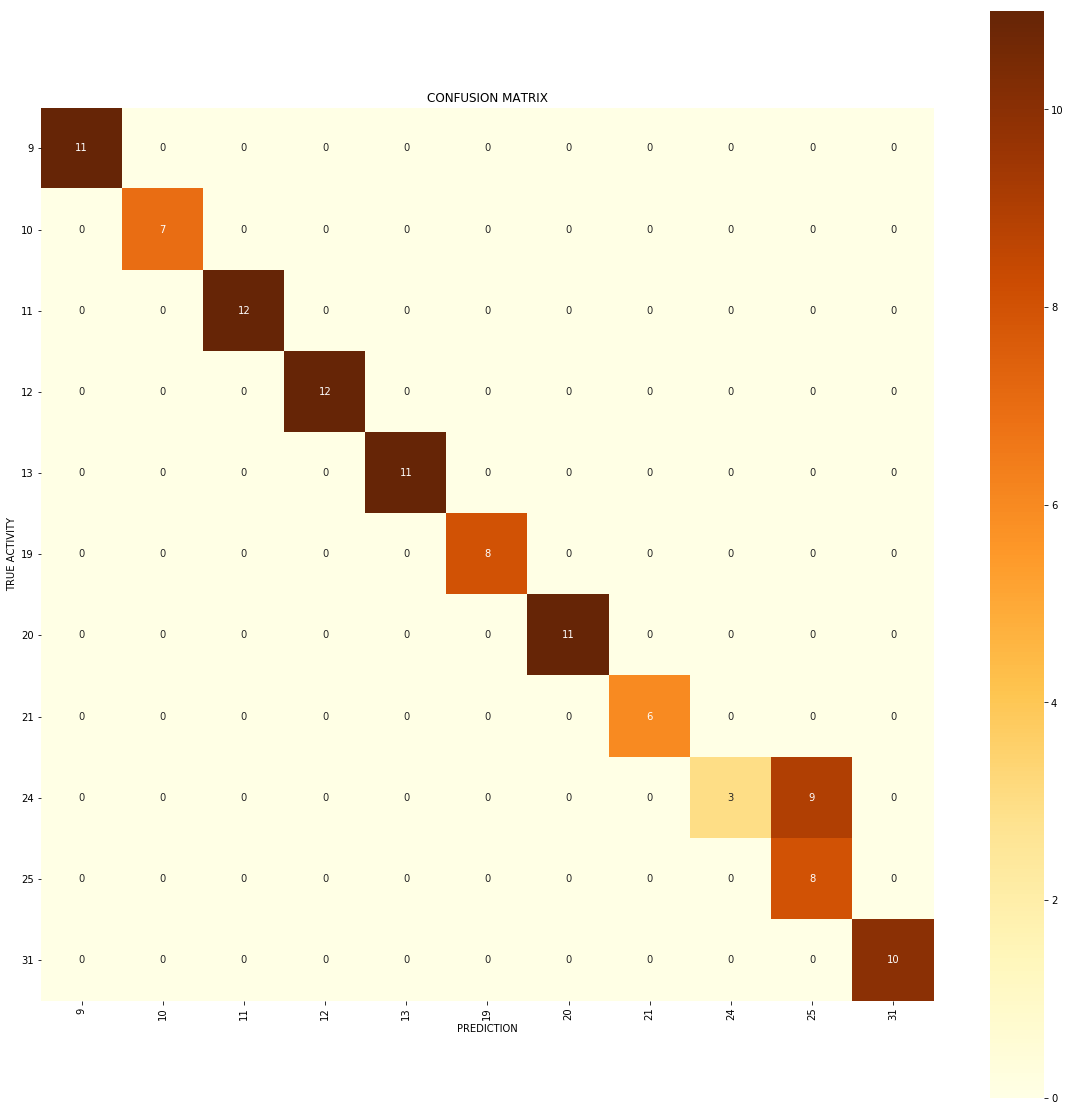

##################################################################################################################################
#####################################################  K-FOLD 4  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


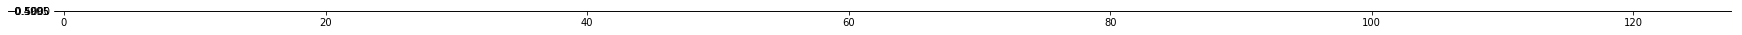

Activity:  11


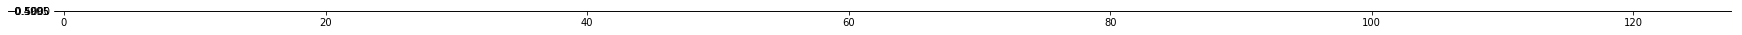

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 5)   

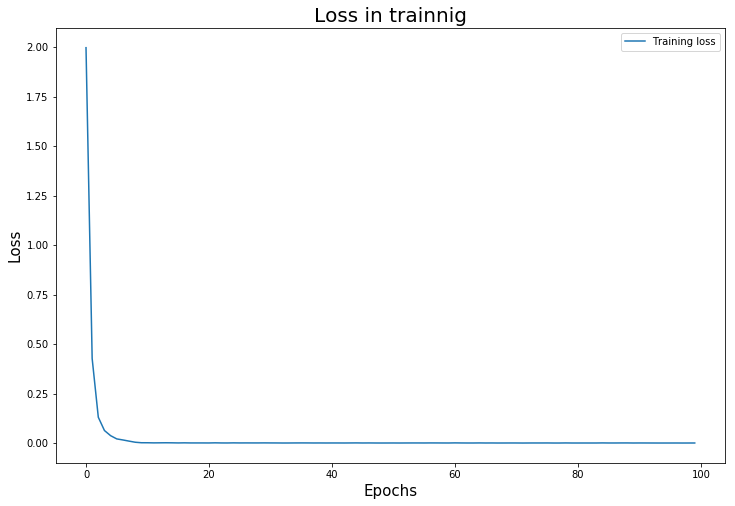

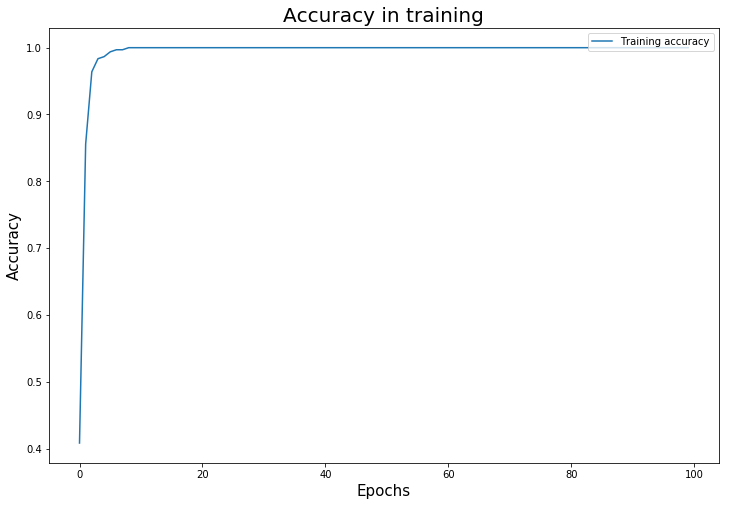

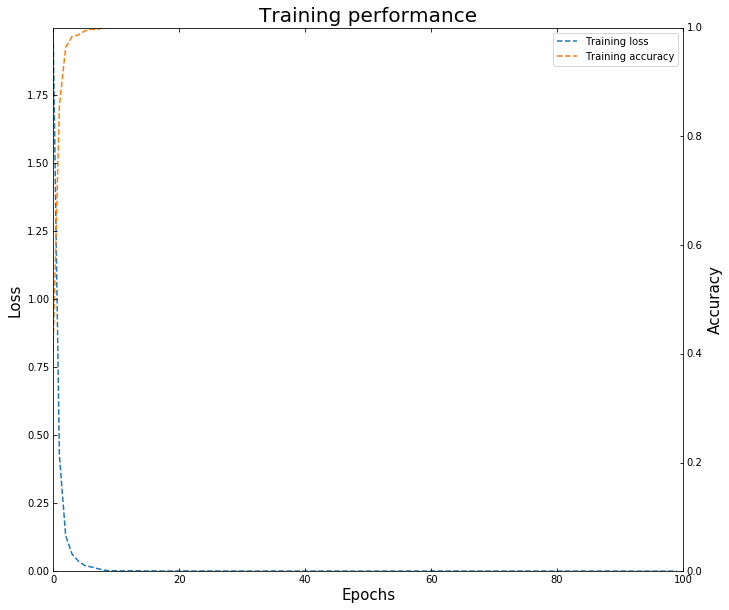

108/108 [==============================] - 0s 1ms/sample
(108, 11)
[[ 5  1  3  0  9  4  4  5  0  8  7  7  1  6  7  8  4  3  3  7  9  9  0  4
  10  1  1  2  4  1  2  5  2  0  5  3  6  0  3  5  6  9  5  7 10  6 10  7
   1  8  1  7  3  9  4  8 10  7  5  8  1  9  5  6  2  7  8  6  1  2  4  1
   4  0  6 10  7  9  2  0  5  4  9  8 10 10  6  1  8  1  2  3 10 10  9  6
   3  7  4  3]]
(108, 1)
[[ 5  1  3  0  9  4  4  5  0  8  7  7  1  6  7  8  4  3  3  7  9  9  0  4
  10  1  1  2  4  1  2  5  2  0  5  3  6  0  3  5  6  9  5  7 10  6 10  7
   1  8  1  7  3  9  4  8 10  7  5  8  1  9  5  6  2  7  8  6  1  2  4  1
   4  0  6 10  7  9  2  0  5  4  9  8 10 10  6  1  8  1  2  3 10 10  9  6
   3  7  4  3]]
108/108 [==============================] - 0s 1ms/sample - loss: 0.0133 - categorical_accuracy: 1.0000


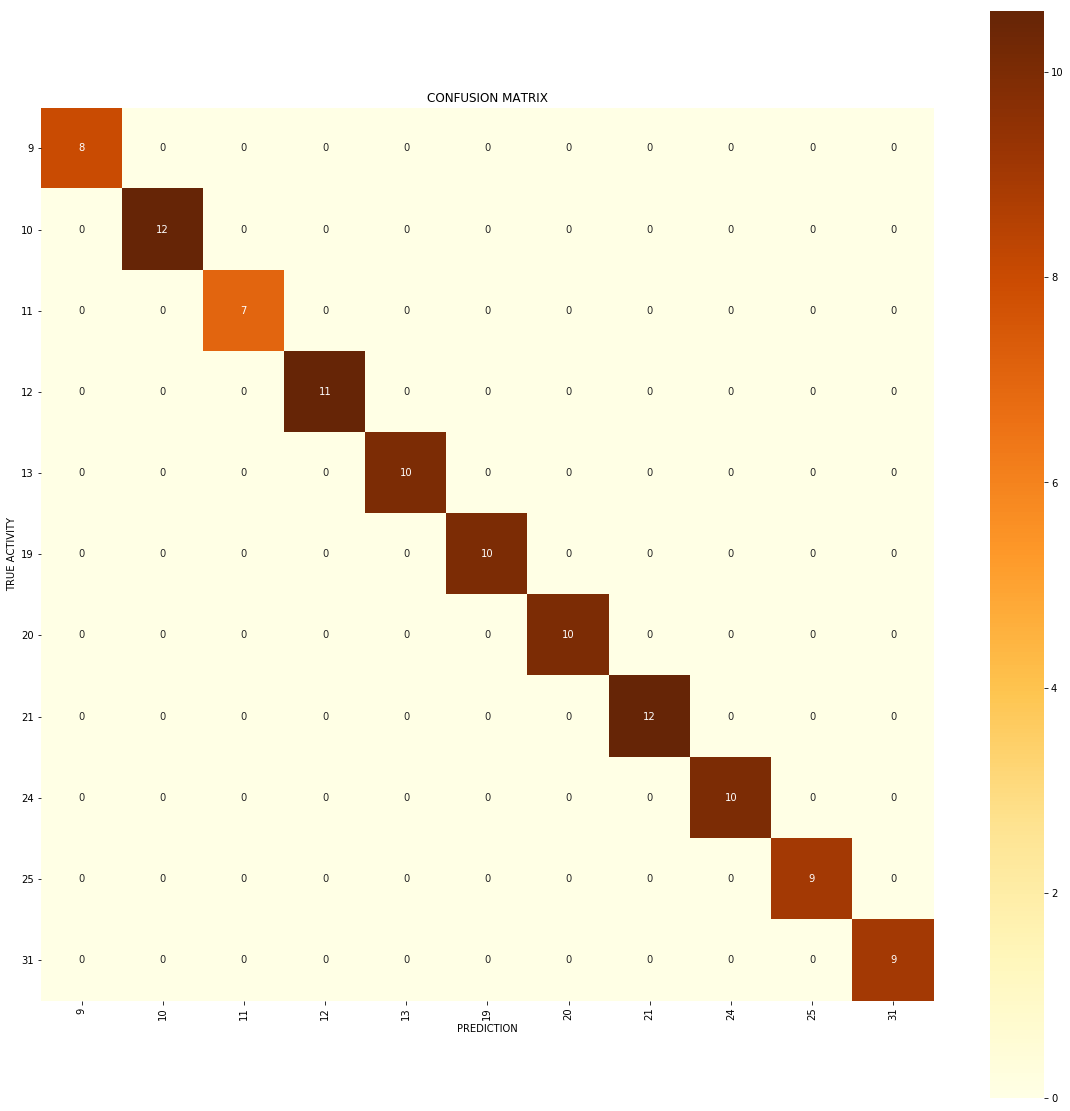

##################################################################################################################################
#####################################################  K-FOLD 5  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


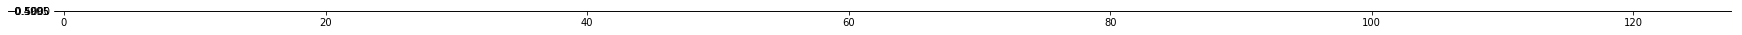

Activity:  11


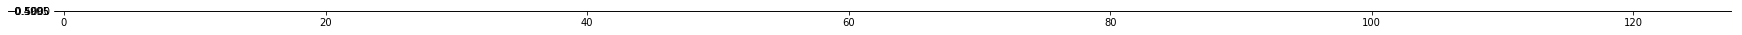

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 5)   

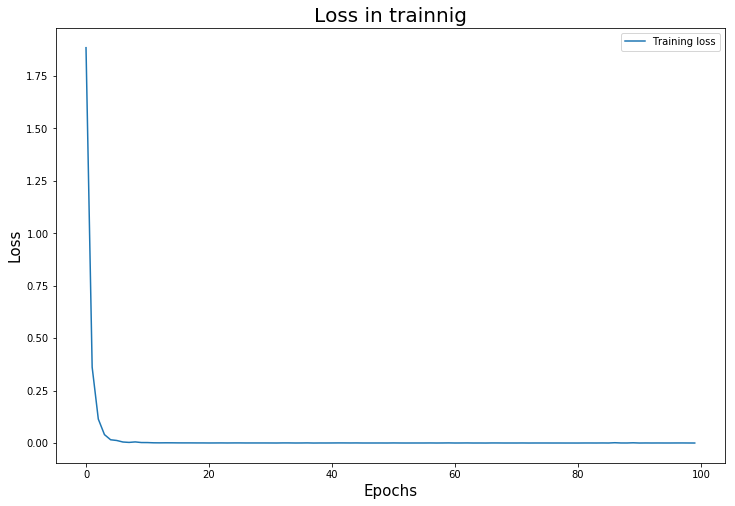

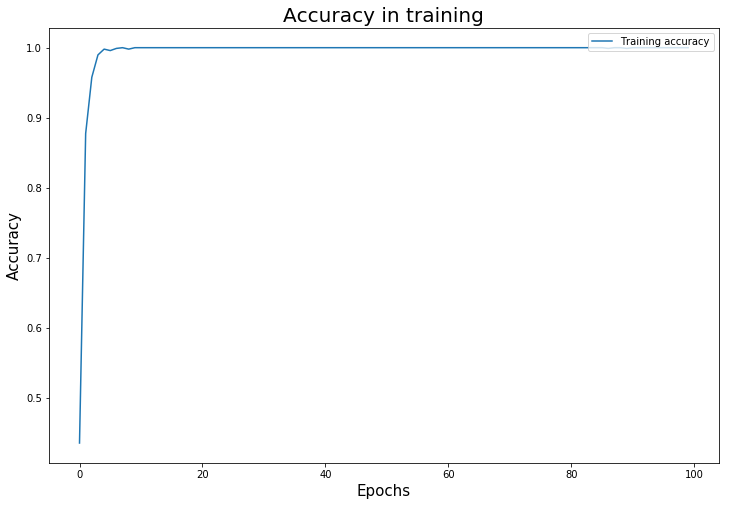

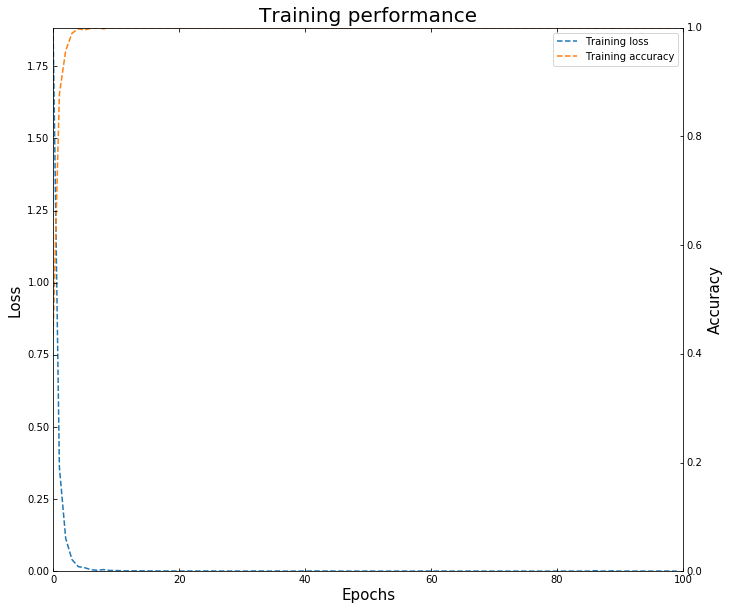

108/108 [==============================] - 0s 1ms/sample
(108, 11)
[[ 1  7  8 10  9  2 10  5  8  2  0  5  5  3  0  1  4  9  1  2  1  4  3  0
   4  0  9  5  6  7  2  0 10  3  9  5  9  9  6  5  6  2  8  1  7  3  4  5
   7  7  6  7  8  8  2  0  4  6  0  3  3  0  8  5  5  0  8 10  0 10  9  4
   6 10  5  2  4  2  8  1  0  0  6 10  5  4  6  8  4  8  6  7  8  4 10  3
   1  2  8  2]]
(108, 1)
[[ 1  7  8 10  9  2 10  5  8  2  0  5  5  3  0  1  4  9  1  2  1  4  3  0
   4  0  9  5  6  7  2  0 10  3  9  5  9  9  6  5  6  2  8  1  7  3  4  5
   7  7  6  7  8  8  2  0  4  6  0  3  3  0  8  5  5  0  8 10  0 10  9  4
   6 10  5  2  4  2  8  1  0  0  6 10  5  4  6  8  4  8  6  7  8  4 10  3
   1  2  8  2]]
108/108 [==============================] - 0s 2ms/sample - loss: 0.0019 - categorical_accuracy: 1.0000


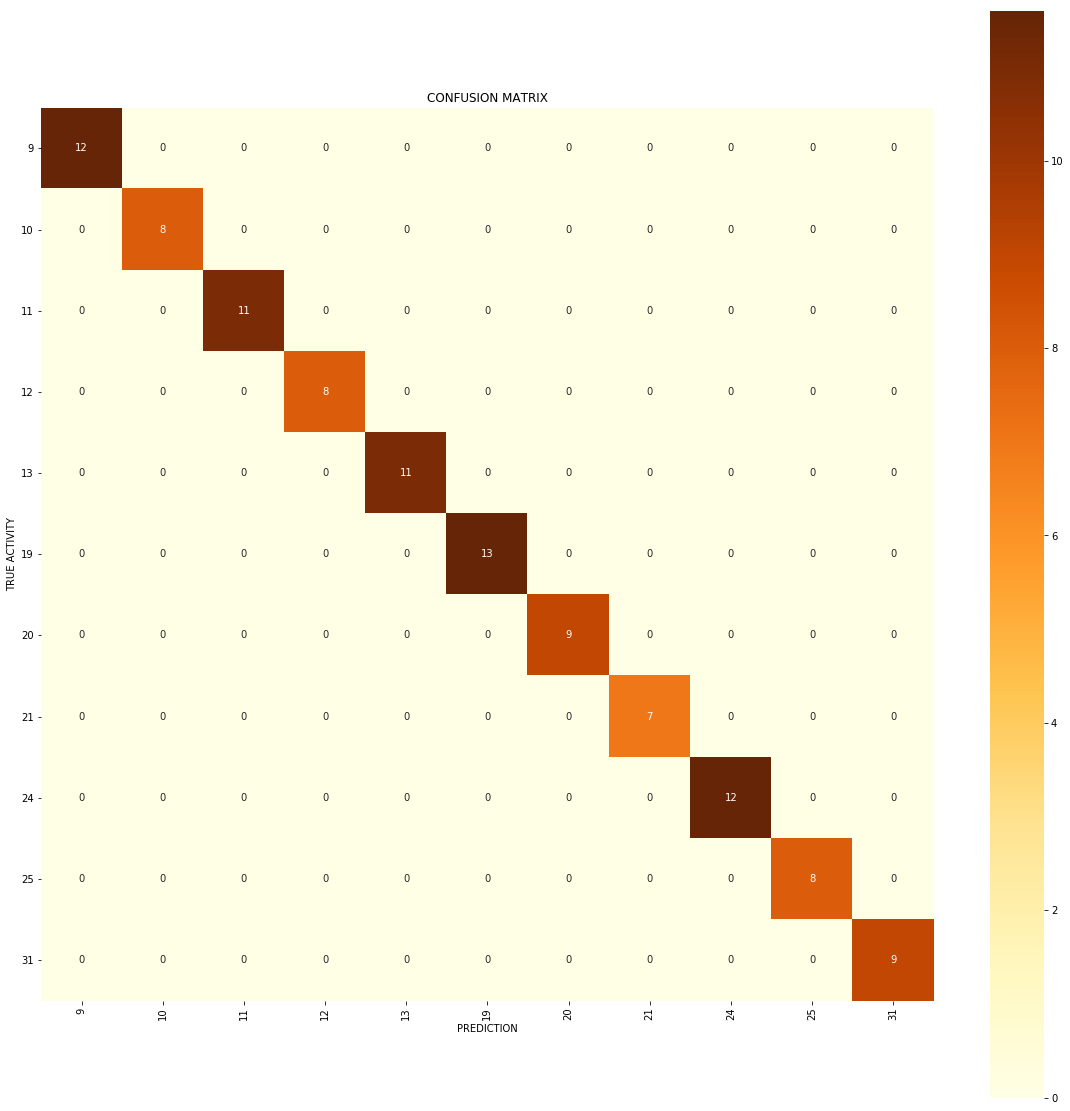

##################################################################################################################################
#####################################################  K-FOLD 6  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


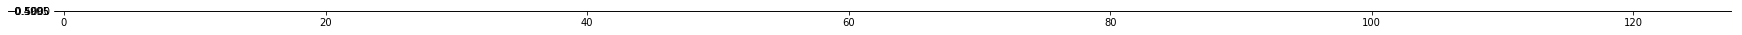

Activity:  11


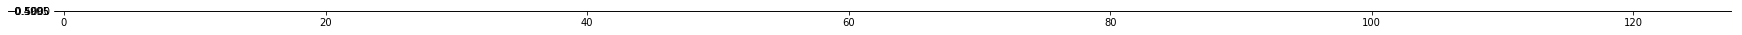

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 5)   

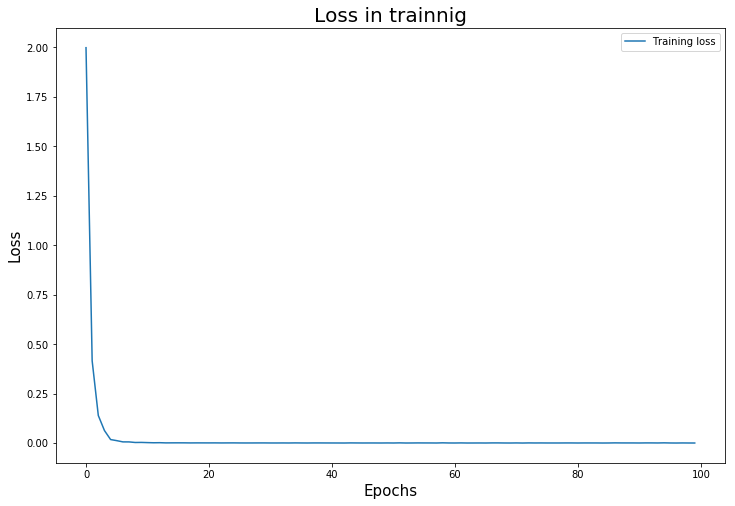

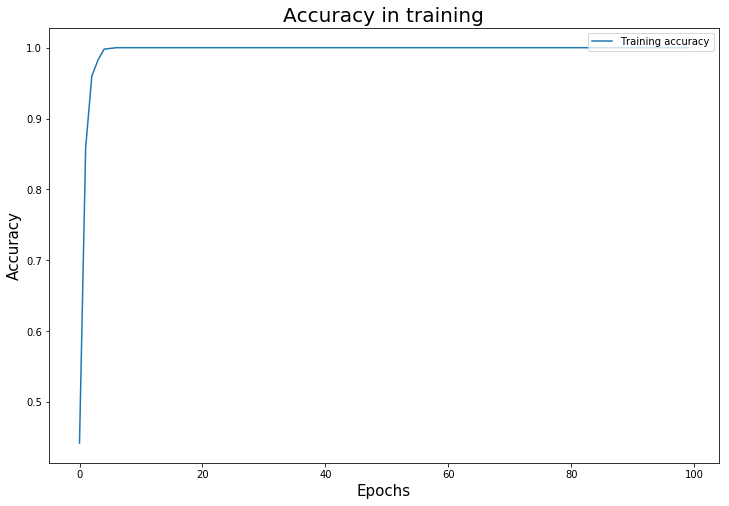

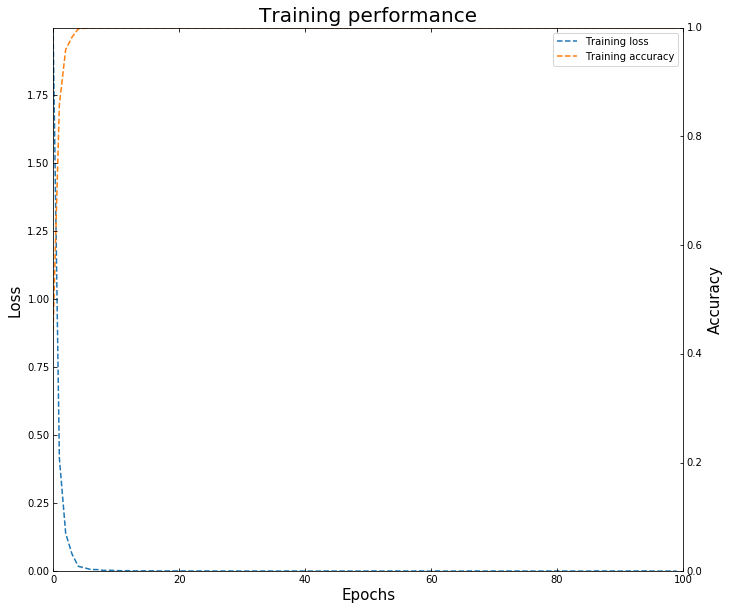

108/108 [==============================] - 0s 2ms/sample
(108, 11)
[[ 1  4  6  3 10  9  2  3  0  2  6  8  2  5  5  1  1  3  3  9 10  2  9  7
   9  3  1  6  9  6  7  9  4  6  7  4  0  9  5  7  7  1  7  1  8  0  7  7
  10  5 10 10  2 10  2  8  7  0  6  9  4  4  3  4  5  2  5  9 10  6  9  9
   0  4  8  7  7  3  5  1  6  4  5  3  9  6  0  0  8  1  6  9  0  1  2  9
   6  8  6  8]]
(108, 1)
[[ 1  4  6  3 10  9  2  3  0  2  6  8  2  5  5  1  1  3  3  9 10  2  9  7
   9  3  1  6  9  6  7  9  4  6  7  4  0  9  5  7  7  1  7  1  8  0  7  7
  10  5 10 10  2 10  2  8  7  0  6  9  4  4  3  4  5  2  5  9 10  6  9  9
   0  4  8  7  7  3  5  1  6  4  5  3  9  6  0  0  8  1  6  9  0  1  2  9
   6  8  6  8]]
108/108 [==============================] - 0s 2ms/sample - loss: 0.0011 - categorical_accuracy: 1.0000


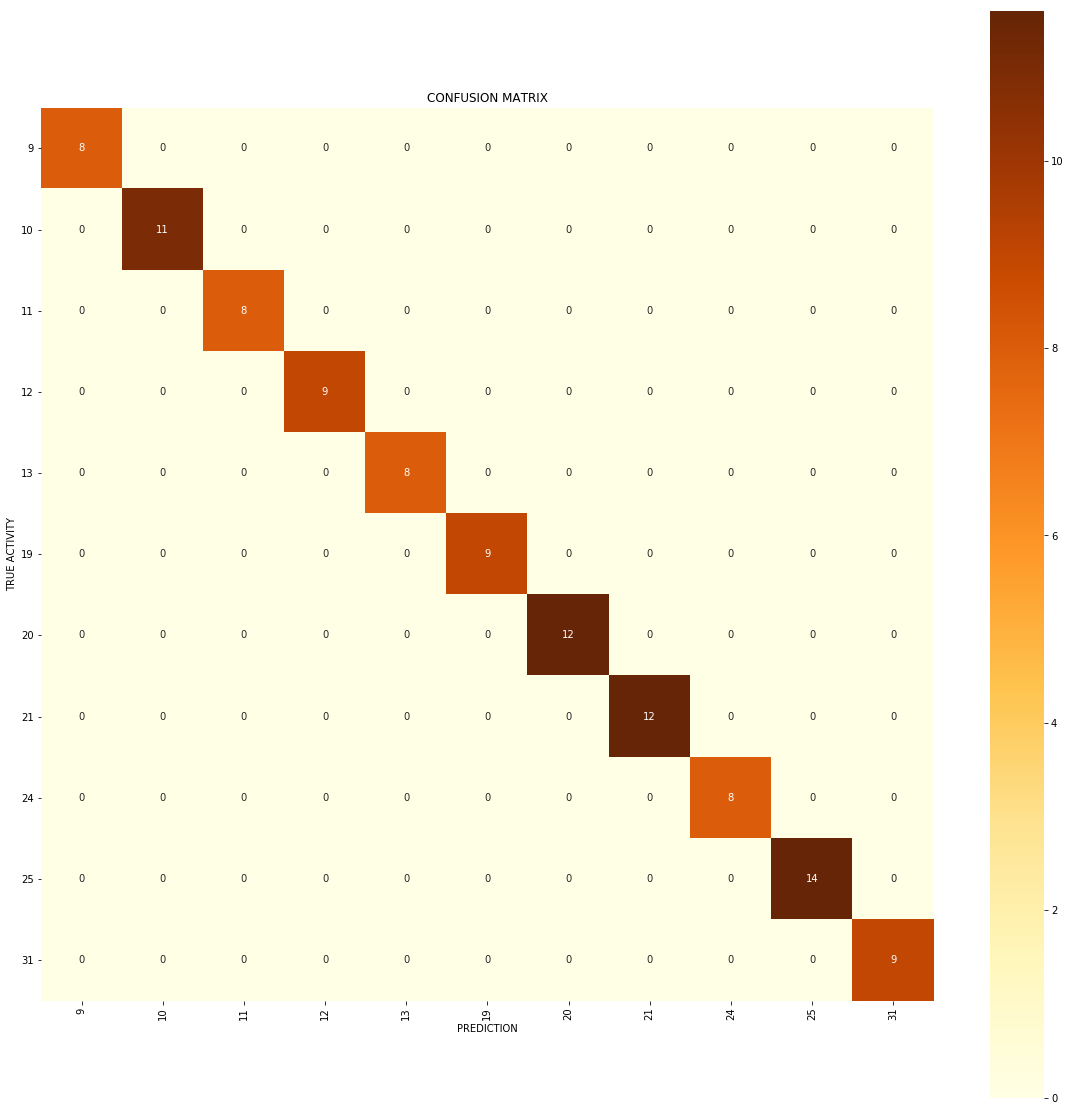

##################################################################################################################################
#####################################################  K-FOLD 7  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


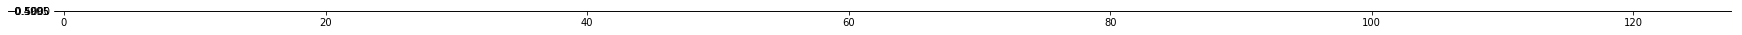

Activity:  11


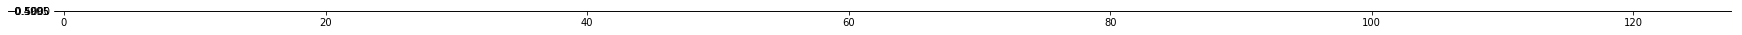

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 5)   

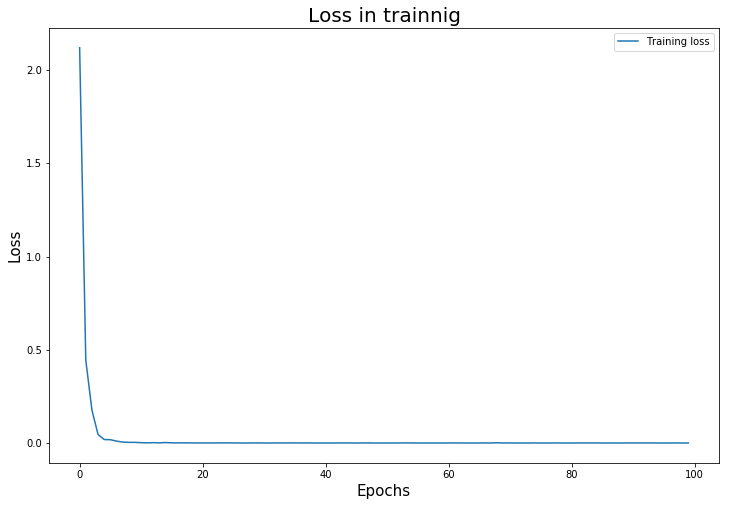

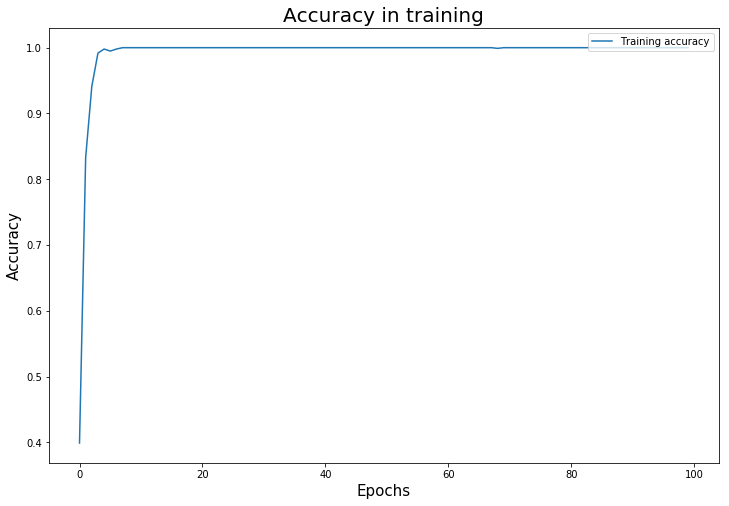

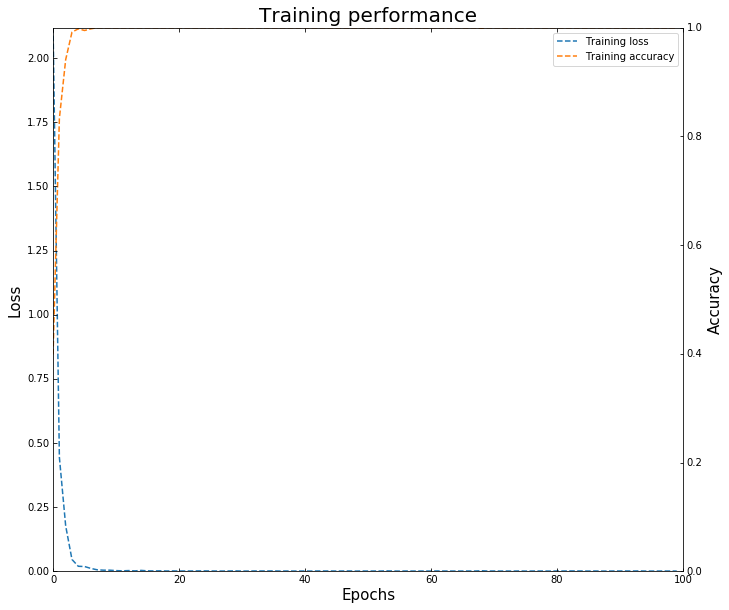

108/108 [==============================] - 0s 2ms/sample
(108, 11)
[[ 5  4  2  2  4  0  2  8  7  7  2  7  7 10  3  8  9  1  6  1  0  9  3  3
   6  5  5  0  8  4  0  7  1  3  2  3  4  1  6  2 10  6  7  9  4  0  0 10
   8 10  6  0  9  1  2  4  7  5  7  5  9  8  6  4  1  4  3  3  4  3  5  0
   9  1  2  4  6  5  1  7  7  4  2  9  8  9 10  2  7  2  6  9  1  5  4  8
   0  5  7  4]]
(108, 1)
[[ 5  4  2  2  4  0  2  8  7  7  2  7  7 10  3  8  9  1  6  1  0  9  3  3
   6  5  5  0  8  4  0  7  1  3  2  3  4  1  6  2 10  6  7  9  4  0  0 10
   8 10  6  0  9  1  2  4  7  5  7  5  9  8  6  4  1  4  3  3  4  3  5  0
   9  1  2  4  6  5  1  7  7  4  2  9  8  9 10  2  7  2  6  9  1  5  4  8
   0  5  7  4]]
108/108 [==============================] - 0s 2ms/sample - loss: 6.0694e-04 - categorical_accuracy: 1.0000


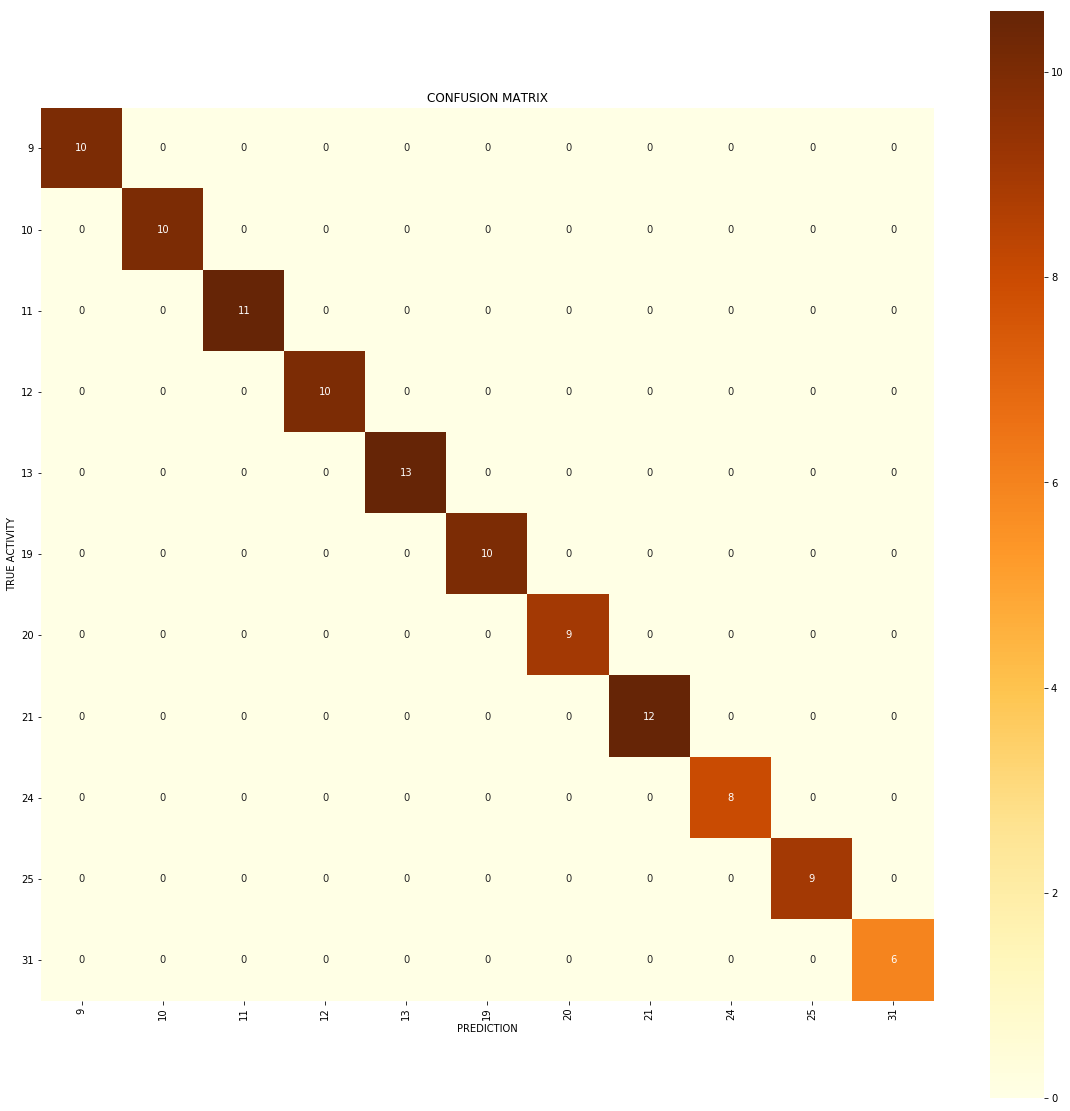

##################################################################################################################################
#####################################################  K-FOLD 8  ################################################################
Train dataset: 
(970, 1, 128, 20) (970, 11)
Test dataset: 
(108, 1, 128, 20) (108, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


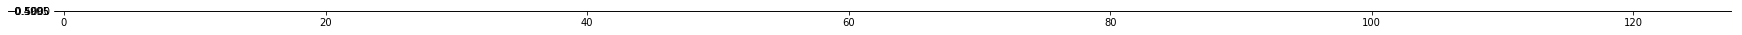

Activity:  11


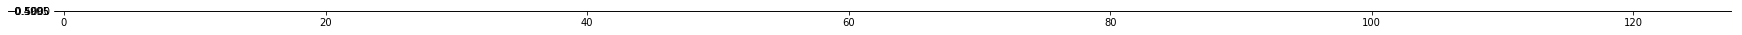

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 5)   

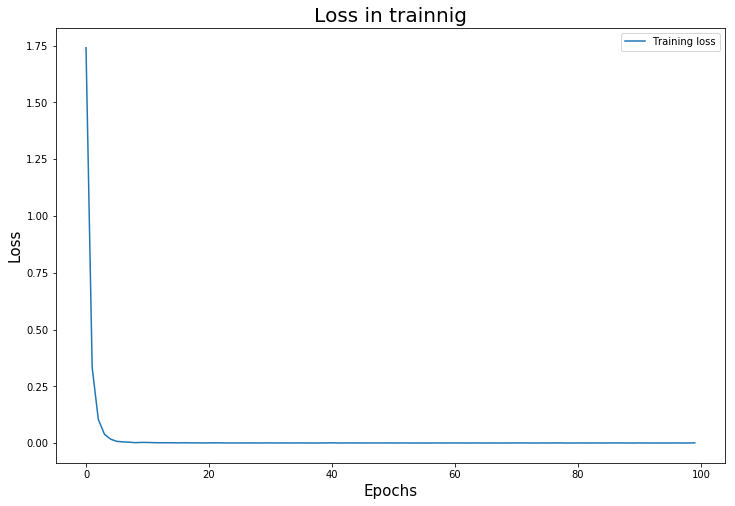

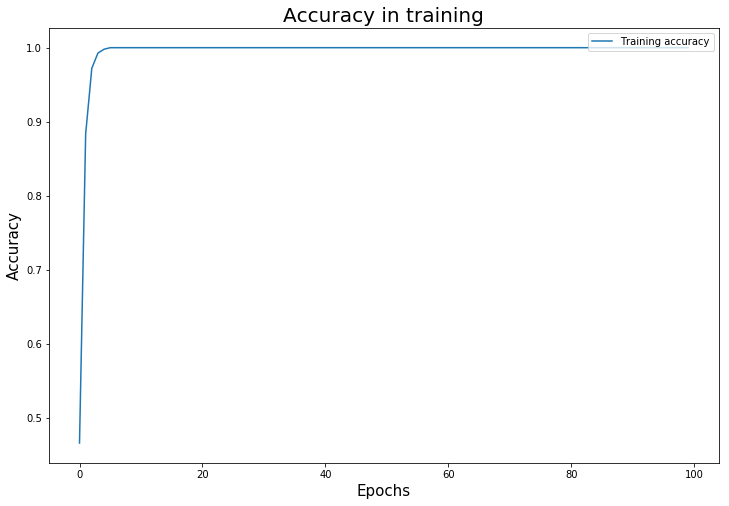

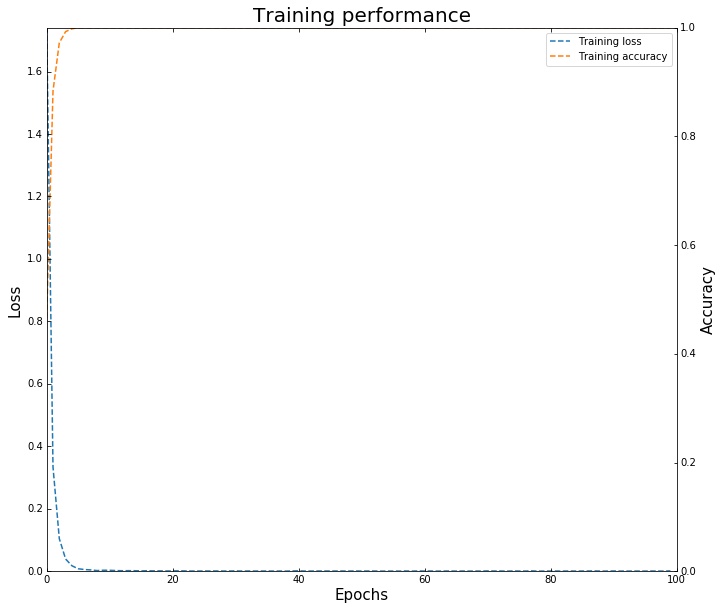

108/108 [==============================] - 0s 2ms/sample
(108, 11)
[[ 8  6  5  2  2  7  0  9  3  2  1  1  8  3  0 10  6  3  8  1 10  9  3  0
   5 10  7  8  9  3  0  0  0  8 10  8  6  8  7  7  1  2  4  6  3  5  6  2
   8  0  3  1  7  5  2  2 10  9  0  1  6  7  4  7 10  6  5  8  8  1  1  3
   4  1  6  7  0  8  5  9  0  7  5  2  9  1  9 10 10  1  4  4  0  2  0  3
   5  2 10  3]]
(108, 1)
[[ 8  6  5  2  2  7  0  9  3  2  1  1  8  3  0 10  6  3  8  1 10  9  3  0
   5 10  7  8  9  3  0  0  0  8 10  8  6  8  7  7  1  2  4  6  3  5  6  2
   8  0  3  1  7  5  2  2 10  9  0  1  6  7  4  7 10  6  5  8  8  1  1  3
   4  1  6  7  0  8  5  9  0  7  5  2  9  1  9 10 10  1  4  4  0  2  0  3
   5  2 10  3]]
108/108 [==============================] - 0s 2ms/sample - loss: 0.0202 - categorical_accuracy: 1.0000


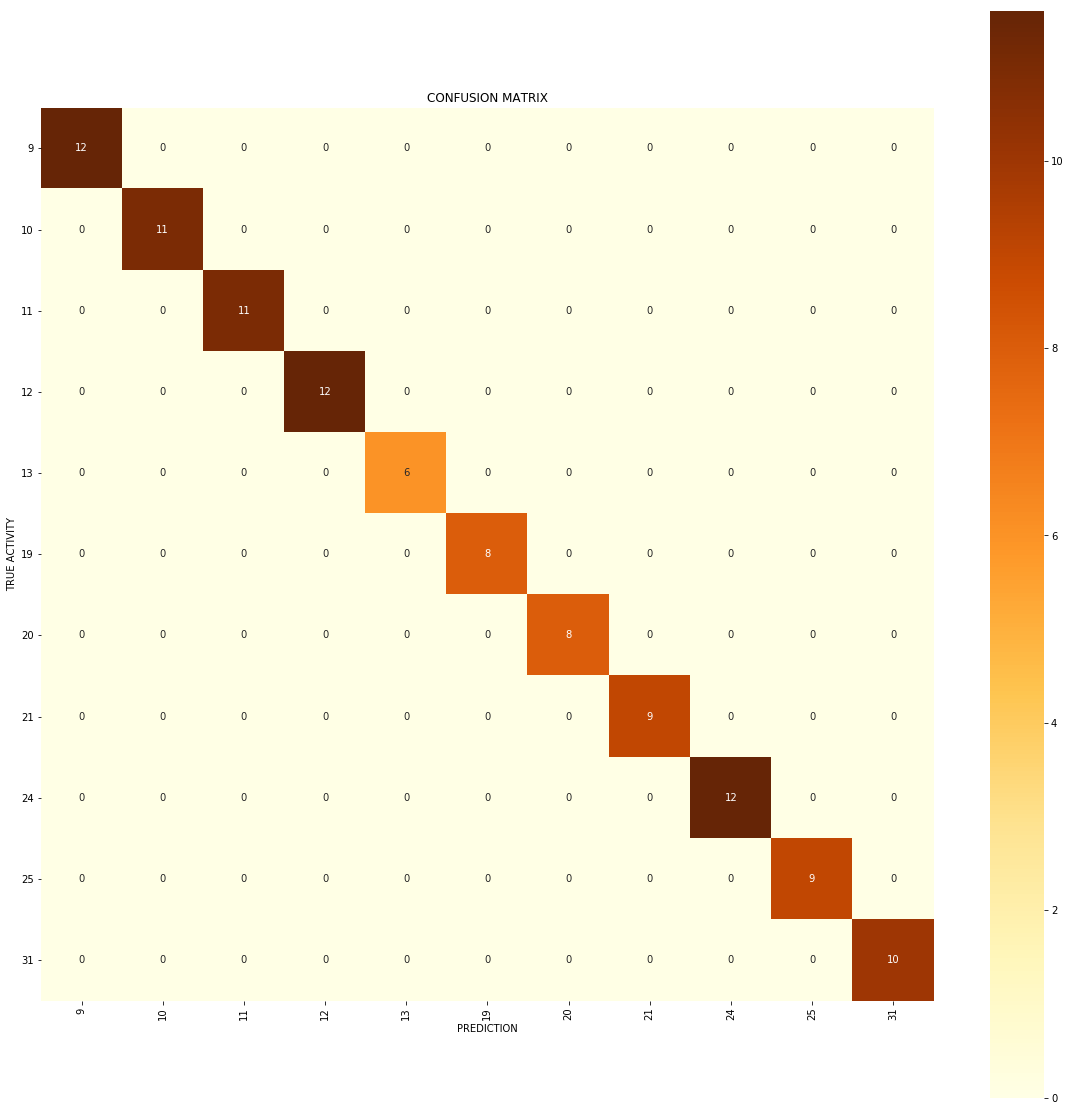

##################################################################################################################################
#####################################################  K-FOLD 9  ################################################################
Train dataset: 
(971, 1, 128, 20) (971, 11)
Test dataset: 
(107, 1, 128, 20) (107, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


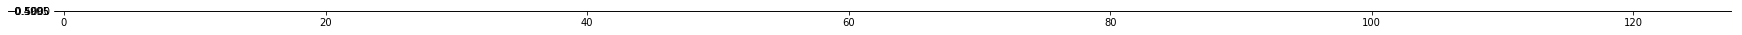

Activity:  11


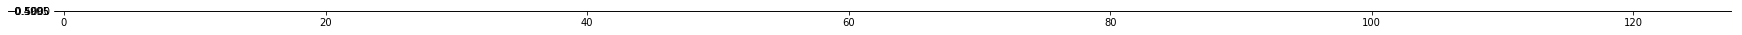

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 5)   

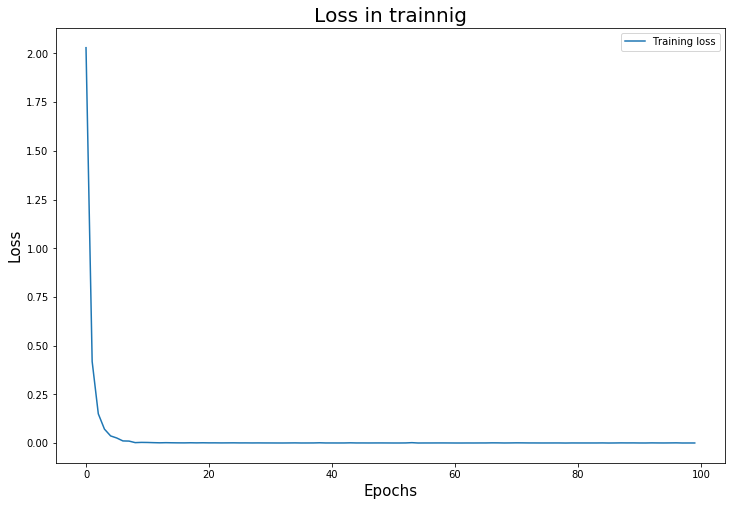

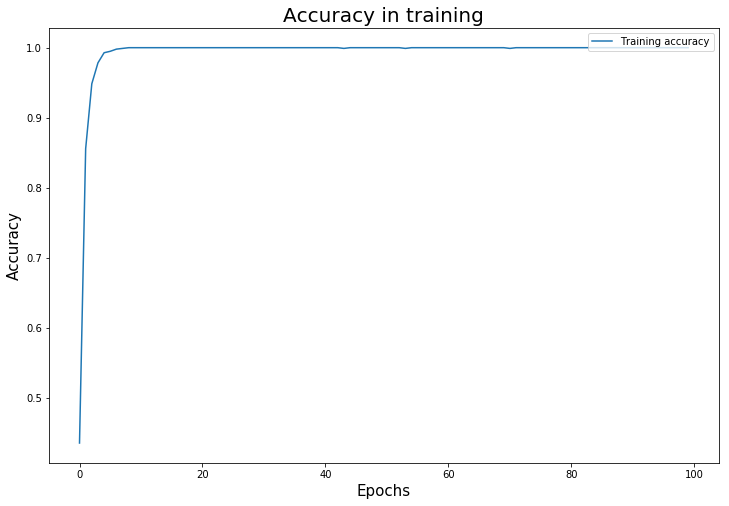

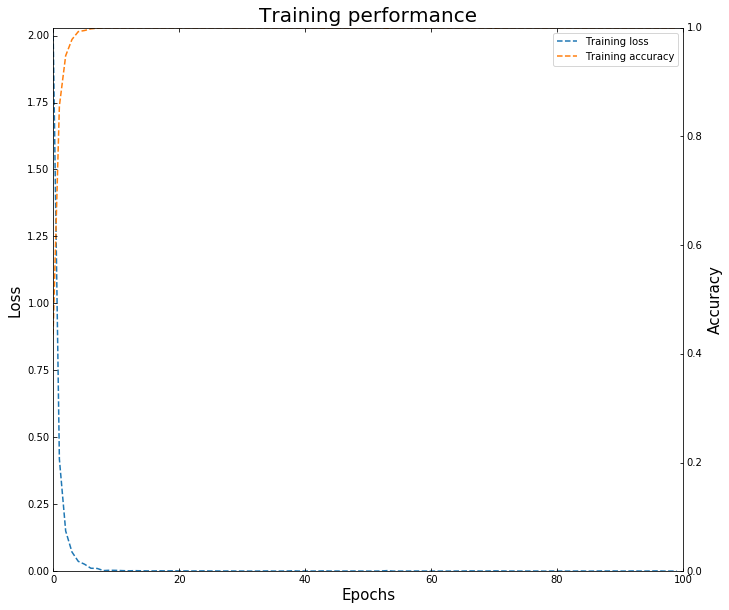

107/107 [==============================] - 0s 3ms/sample
(107, 11)
[[ 4  1  9  6  5  5  8  3  2  6  4  7  4  6  7  5 10  9  1  3  1  4  8  4
   4  4  5  7  7  9  7  5  1  7  8  3  4  4  4 10  3  3  3  4  3  3  9  3
   1  5  4  8  1  7  7  9  6  6  4  4  8 10  4  1  5  1  5  6  9  5  3  5
   4  4  4  7  3  3  6  3  4  3  8  3  9  9  3  8 10  3  5  1  6  7 10  9
   6 10 10  6]]
(107, 1)
[[ 4  1  9  6  5  5  8  3  2  6  4  7  4  6  7  5 10  9  1  3  1  4  8  4
   0  0  5  7  7  9  7  5  1  7  8  3  4  2  4 10  2  3  2  4  3  2  9  3
   1  9  4  8  1  7  7  9  6  6  0  4  8 10  4  1  5  1  5  6  9  5  2  5
   0  0  0  7  2  2  6  3  0  3  8  3  9  9  2  8 10  2  5  1  0  7 10  9
   6 10 10  6]]
107/107 [==============================] - 0s 3ms/sample - loss: 0.7241 - categorical_accuracy: 0.8224


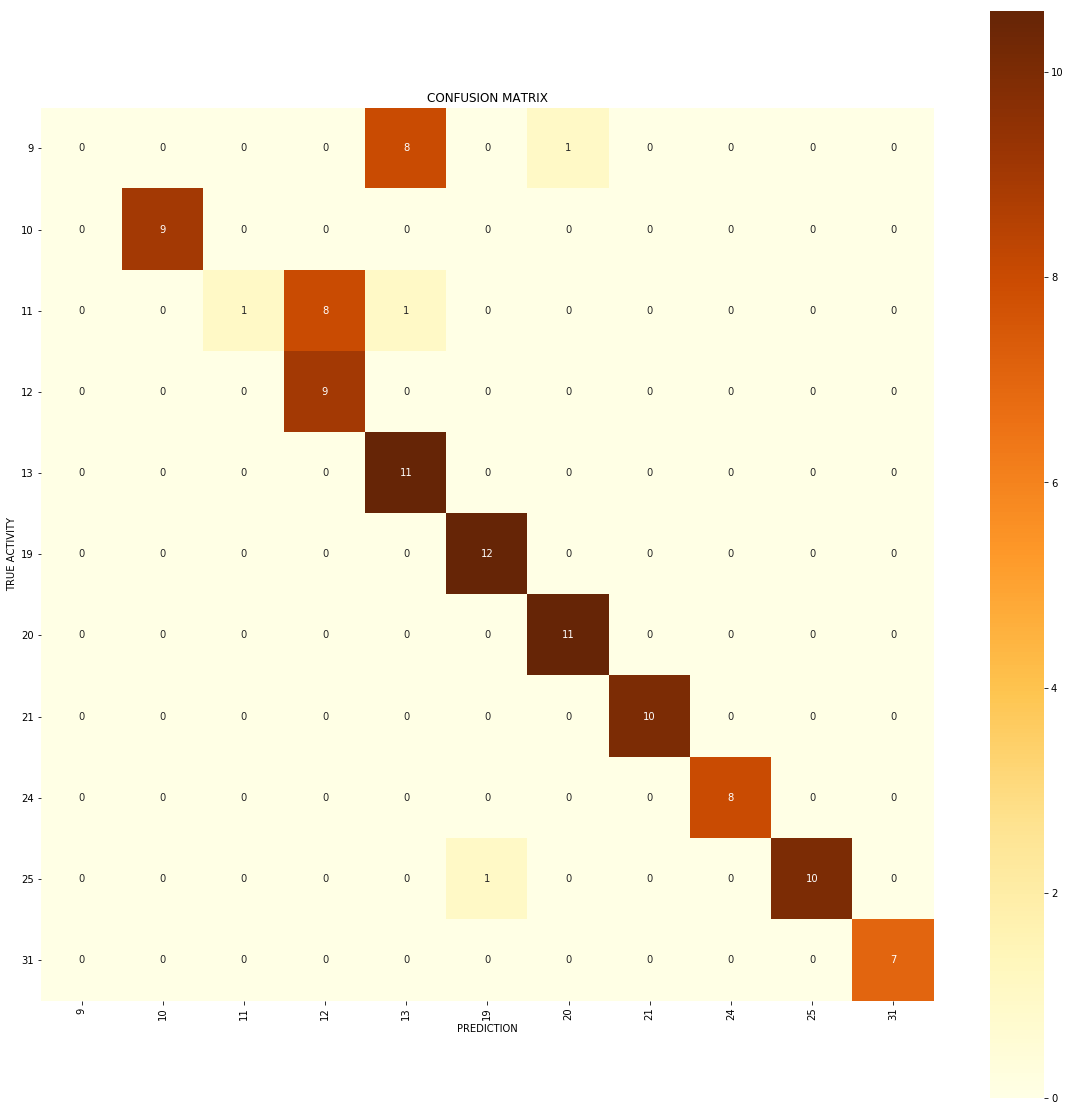

##################################################################################################################################
#####################################################  K-FOLD 10  ################################################################
Train dataset: 
(971, 1, 128, 20) (971, 11)
Test dataset: 
(107, 1, 128, 20) (107, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


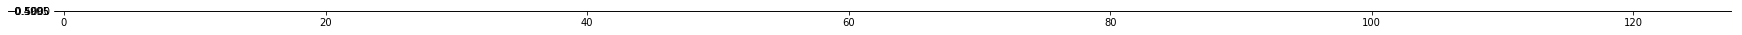

Activity:  11


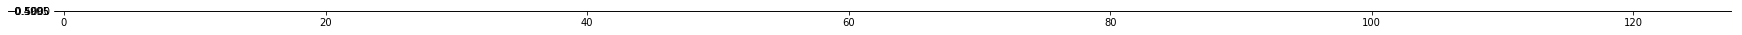

Activity:  31
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 5)   

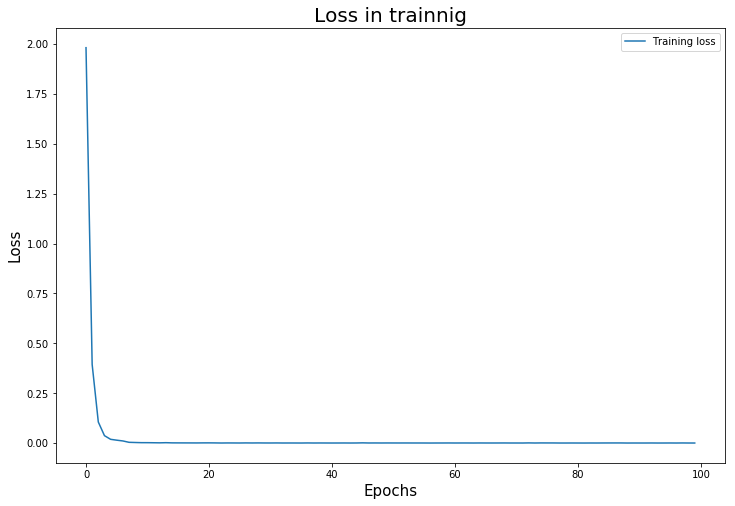

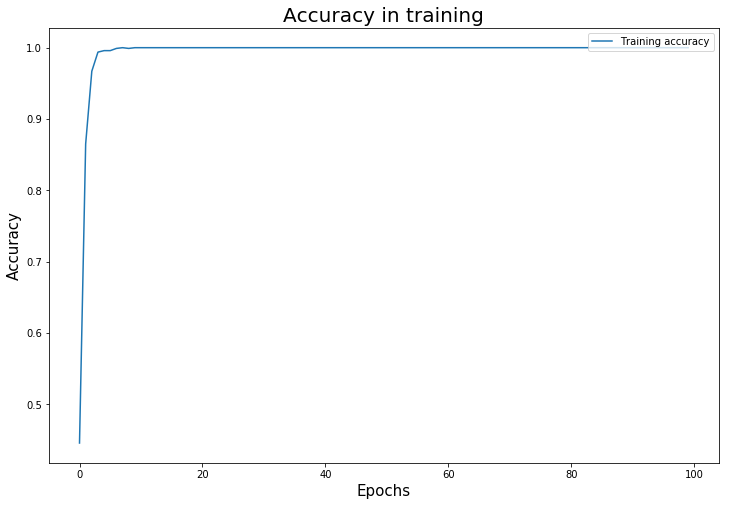

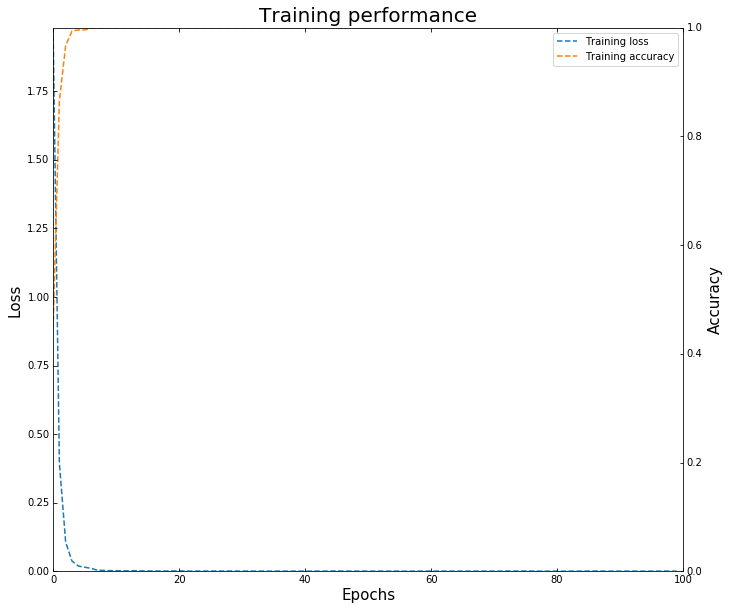

107/107 [==============================] - 0s 2ms/sample
(107, 11)
[[10  6  1  8 10  8  4  3  7  7  5  7  5  0  7  7  5  1  7  3  7  3  6  0
  10  0  5  7  0  7 10  5  7  7  3  0  7  5  1 10  5  6  1 10  3  5  1  0
   3  7  2  7 10  7  7  7  6 10  6  3  0  2  6  6  3  0  1  1 10  7  2  6
   7  5  0  2  2 10  7  2 10 10  5  0  7  2  0  0  0  0  0  7  1  0  5  7
   0  3  3  1]]
(107, 1)
[[10  6  1  8 10  8  4  3  7  7  9  7  5  0  8  9  5  1  8  3  9  3  6  4
  10  0  5  8  4  8 10  5  9  8  3  0  7  9  1 10  5  6  1  6  3  5  1  4
   3  9  2  9 10  8  7  8  6 10  6  3  0  2  6  6  3  4  1  1 10  7  2  6
   7  5  4  2  2 10  9  2 10  6  5  4  7  2  0  4  4  4  0  9  1  0  5  7
   0  3  3  1]]
107/107 [==============================] - 0s 2ms/sample - loss: 1.7481 - categorical_accuracy: 0.7290


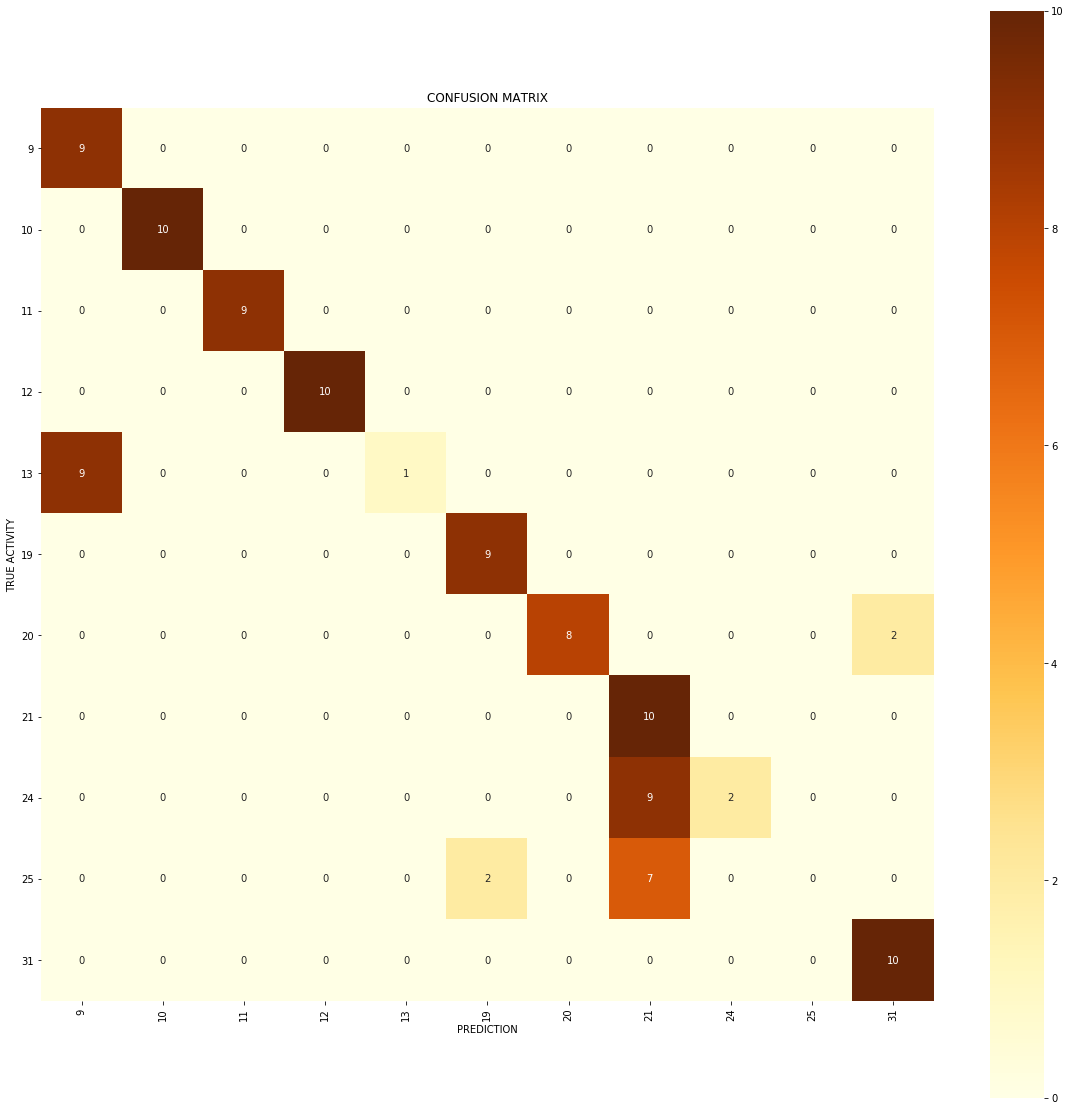

In [11]:
accuracies = []
for i in range(10):
    if(i<10):
        kfold='0'+str(i)
    else:
        kfold=str(i)
    print('##################################################################################################################################')
    print('#####################################################  K-FOLD %d  ################################################################'%(i+1))
    
    subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
    
    ##  GENERACIÓN DATASET
    tr_seg = np.concatenate((np.load('./raw/subject_'+subjects[0]+'_seg.npy'),np.load('./raw/subject_'+subjects[1]+'_seg.npy'),np.load('./raw/subject_'+subjects[2]+'_seg.npy'),np.load('./raw/subject_'+subjects[3]+'_seg.npy'),
                             np.load('./raw/subject_'+subjects[4]+'_seg.npy'),np.load('./raw/subject_'+subjects[5]+'_seg.npy'),np.load('./raw/subject_'+subjects[6]+'_seg.npy'),np.load('./raw/subject_'+subjects[7]+'_seg.npy'),
                             np.load('./raw/subject_'+subjects[8]+'_seg.npy'),np.load('./raw/subject_'+subjects[9]+'_seg.npy'),np.load('./raw/subject_'+subjects[10]+'_seg.npy')))

    tr_lab = np.concatenate((np.load('./raw/subject_'+subjects[0]+'_lab.npy'),np.load('./raw/subject_'+subjects[1]+'_lab.npy'),np.load('./raw/subject_'+subjects[2]+'_lab.npy'),np.load('./raw/subject_'+subjects[3]+'_lab.npy'),
                             np.load('./raw/subject_'+subjects[4]+'_lab.npy'),np.load('./raw/subject_'+subjects[5]+'_lab.npy'),np.load('./raw/subject_'+subjects[6]+'_lab.npy'),np.load('./raw/subject_'+subjects[7]+'_lab.npy'),
                             np.load('./raw/subject_'+subjects[8]+'_lab.npy'),np.load('./raw/subject_'+subjects[9]+'_lab.npy'),np.load('./raw/subject_'+subjects[10]+'_lab.npy')))
    
    limit = 20
    tr_seg = tr_seg[:,:,:,:limit]
    ####################################################################################################################
    ## SHUFFLE DE DATOS
    np.random.seed(235)
    tr_seg = np.reshape(tr_seg[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (1078,1,128,limit))
    tr_lab = np.reshape(tr_lab[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (1078,11))
    
    ts_seg = tr_seg[S_test[i]]
    ts_lab = tr_lab[S_test[i]]
    
    tr_seg = tr_seg[S_train[i]]
    tr_lab = tr_lab[S_train[i]]
    
    print('Train dataset: ')
    print(tr_seg.shape, tr_lab.shape)
    print('Test dataset: ')
    print(ts_seg.shape, ts_lab.shape)
    ####################################################################################################################
    ## VISTA DE DFT-2D
    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.abs(np.fft.fftshift(tr_seg[0,0,:,20:40].T))**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[0])])

    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.fft.fftshift(tr_seg[10,0,:,20:40].T)**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[10])])
    ####################################################################################################################
    ## RED
    quat_input = keras.Input(shape=(n_channels, n_time_steps, n_columns), name='input_layer')

    # Initializer
    #initializer = RandomNormal(mean=0.0, stddev=0.02)

    # Some convolutional layers
    conv_1 = keras.layers.Conv2D(16, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(quat_input)#, kernel_initializer=initializer)(quat_input)
    max_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_1)
    bn_1 = keras.layers.BatchNormalization(axis=1)(max_1)

    conv_2 = keras.layers.Conv2D(32, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_1)#, kernel_initializer=initializer)(max_1)
    max_2 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_2)
    bn_2 = keras.layers.BatchNormalization(axis=1)(max_2)

    conv_3 = keras.layers.Conv2D(64, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_2)#, kernel_initializer=initializer)(re_2)
    max_3 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_3)
    bn_3 = keras.layers.BatchNormalization(axis=1)(max_3)

    conv_4 = keras.layers.Conv2D(128, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_3)#, kernel_initializer=initializer)(re_2)
    max_4 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_4)
    bn_4 = keras.layers.BatchNormalization(axis=1)(max_4)

    # Flatten the output of the convolutional layers
    conv_flat = keras.layers.Flatten()(bn_4)

    dr_2 = keras.layers.Dropout(0.5)(conv_flat)

    # Output layers: separate outputs for the weather and the ground labels
    multiclass_output = keras.layers.Dense(n_classes, activation='softmax',name='activity_class')(dr_2)

    # Creamos la estrcutura que contendrá a nuestro modelo
    model = keras.Model(inputs=quat_input, outputs=[multiclass_output],name='cnn')

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    print(model.summary())
    ####################################################################################################################
    ## TRAIN
    history = model.fit(tr_seg,
                        tr_lab,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list)
    model.save('./01RAW_RP_KFOLD_models/CNN_'+kfold+'.h5')
    
    #Visualize training evolution
    plot_curves(model, 'categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', kfold)
    ####################################################################################################################
    ## TEST
    predictions = model.predict(ts_seg, batch_size = batch_size, verbose = 1)
    
    print(predictions.shape)
    
    y_pred = np.argmax(predictions,axis=-1)
    y_pred = np.expand_dims(y_pred,axis=-1)
    print(y_pred[:100].T)
    
    y_true = np.argmax(ts_lab,axis=-1)
    y_true = np.expand_dims(y_true,axis=-1)
    print(y_true.shape)
    print(y_true[:100].T)
    
    evaluation = model.evaluate(ts_seg, ts_lab, batch_size=batch_size, verbose=1)
    accuracies.append(evaluation[1])
    
    fo = open('./01RAW_RP_KFOLD_models/accuracy_'+kfold+'.txt', "w")
    fo.seek(0,2)
    fo.write(str(evaluation))
    fo.close()
    
    ####################################################################################################################
    ## CONFUSION MATRIX
    y_true_flat = np.ndarray.flatten(y_true)
    y_pred_flat = np.ndarray.flatten(y_pred)
    
    plot_confusion_matrix(y_true_flat, y_pred_flat, kfold, classes=activities)
    
    del kfold, limit, tr_seg, tr_lab, ts_seg, ts_lab, model, history, y_pred, y_true, predictions, evaluation, y_true_flat, y_pred_flat
    

# Accuracy

In [12]:
sum = 0
for acc in accuracies:
    sum += acc
print('Accuracy of K-Fold: ' + str(sum/10))

Accuracy of K-Fold: 0.9134735226631164
